In [12]:
# this notebook will use a basic GPT based decision transformer in offline reinforcement learning setting to create bot for trading stock
# get cuda device
# import libraries
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

from cust_transf import DecisionTransformer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
from datasets.load import load_dataset
from datasets import Dataset

# load huggingface dataset from json file in replaybuffer folder
foldername = 'replaybuffer'

# get filenames in folder
import os
filenames = os.listdir(foldername)

# get full path of files
full_filenames = [os.path.join(foldername, filename) for filename in filenames]

data = load_dataset("json", data_files = full_filenames[0], field = 'data')


Found cached dataset json (/home/victoru/.cache/huggingface/datasets/json/default-fee53e086325bcc9/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 1/1 [00:00<00:00, 948.51it/s]


In [14]:
from datasets.load import load_dataset
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

# utility function to compute the discounted cumulative sum of a vector
def discount_cumsum(x, gamma):
    disc_cumsum = np.zeros_like(x)
    disc_cumsum[-1] = x[-1]
    for t in reversed(range(x.shape[0]-1)):
        disc_cumsum[t] = x[t] + gamma * disc_cumsum[t+1]
    return disc_cumsum

def compute_rtg(data, gamma, rtg_scale):
    rtg = []
    for reward in data['reward'].apply(lambda x: discount_cumsum(np.array(x, dtype=np.float32), gamma)/rtg_scale):
        rtg.append(reward)
    return rtg

# define a custom dataset class which loads the data, modifies the reward to be the discounted cumulative sum and apply trajectory masking
class CustomTrajDataset(Dataset):
    def __init__(self, file_name, context_len, gamma, rtg_scale):
        self.gamma = gamma
        self.context_len = context_len

        self.data = load_dataset("json", data_files = file_name, field = 'data')['train']

        self.data = self.data.with_format('pandas')
        #min_len = 10**6

        # calculate mean and std of states
        states = []

        for traj in self.data['state']:
            states.append(traj)
            #if len(traj) < min_len:
            #    min_len = len(traj)
        states = np.concatenate(states, axis=0)
        self.state_mean, self.state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6

        # calculate rtg
        self.rtg = pd.Series(compute_rtg(self.data, gamma, rtg_scale))

        # get the len of the dataset
        self.stateshape = len(self.data['state'])


    def get_state_stats(self):
        return self.state_mean, self.state_std        

    def __len__(self):
        return self.stateshape

    def __getitem__(self, idx):
        try:

            state = np.stack(self.data['state'][idx])
            action = np.stack(self.data['action'][idx])
            rtg = self.rtg[idx]
        except IndexError:
            # handle index out of range error
            raise IndexError(f"Index {idx} out of range for dataset with length {len(self.data['state'])}")


        data_len = state.shape[0]
        
        if data_len > self.context_len:
            # sample random start index
            start_idx = np.random.randint(0, data_len - self.context_len)
            # slice the data and convert to torch
            state = torch.from_numpy(state[start_idx:start_idx+self.context_len])
            action = torch.from_numpy(action[start_idx:start_idx+self.context_len])
            rtg = torch.from_numpy(rtg[start_idx:start_idx+self.context_len])
            timesteps = torch.arange(start=start_idx, end=start_idx + self.context_len, step=1)
            # trajectory mask
            mask = torch.ones(self.context_len, dtype=torch.long)
        else:
            padding_len = self.context_len - data_len

            # pad the data with zeros
            state = torch.from_numpy(state)
            state = torch.cat([state, torch.zeros((padding_len, *state.shape[1:]))], dim=0)

            action = torch.from_numpy(action)
            action = torch.cat([action, torch.zeros((padding_len, *action.shape[1:]))], dim=0)

            rtg = torch.from_numpy(rtg)
            rtg = torch.cat([rtg, torch.zeros((padding_len, *rtg.shape[1:]))], dim=0)

            timesteps = torch.arange(start=0, end=self.context_len, step=1)

            # trajectory mask
            mask = torch.cat([torch.ones(data_len, dtype=torch.long), torch.zeros(padding_len, dtype=torch.long)], dim=0)

        """
        Exepected output type and shape
        state type:  torch.float32
        actions type:  torch.float32
        rtg type:  torch.float32
        timestep type:  torch.int64
        traj_mask type:  torch.int64
        shape state: torch.Size([32, 30, 13])
        shape rtg: torch.Size([32, 30, 1])
        shape timestep: torch.Size([32, 30])
        shape actions: torch.Size([32, 30, 2])
        """
        
        return state.float(), action.float(), rtg.unsqueeze(-1), timesteps, mask


In [15]:
# load huggingface dataset from json file in replaybuffer folder
foldername = 'replaybuffer'

# get filenames in folder
import os
filenames = os.listdir(foldername)

# get full path of files
full_filenames = [os.path.join(foldername, filename) for filename in filenames]

# create datasets and store in list from the list of filenames 
context_len = 30
rtg_scale = 1e4
gamma = 0.8

datasets = []

for name in full_filenames:
    dataset = CustomTrajDataset(name, context_len, gamma, rtg_scale)
    print(f"{name} has {len(dataset)} trajectories")
    datasets.append(dataset)


# concatenate all datasets
combined_dataset = torch.utils.data.ConcatDataset(datasets)
print(f"combined_dataset has {len(combined_dataset)} trajectories")



Found cached dataset json (/home/victoru/.cache/huggingface/datasets/json/default-fee53e086325bcc9/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 1/1 [00:00<00:00, 921.22it/s]
/tmp/ipykernel_6978/4280996087.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for reward in data['reward'].apply(lambda x: discount_cumsum(np.array(x, dtype=np.float32), gamma)/rtg_scale):


replaybuffer/AAPL_2555_2015-01-01_1d_random_replaybuffer.json has 500 trajectories


Found cached dataset json (/home/victoru/.cache/huggingface/datasets/json/default-0d2b6431758d253c/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 1/1 [00:00<00:00, 985.74it/s]
/tmp/ipykernel_6978/4280996087.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for reward in data['reward'].apply(lambda x: discount_cumsum(np.array(x, dtype=np.float32), gamma)/rtg_scale):


replaybuffer/AAPL_test_len_14_1_1d_ppo_replaybuffer.json has 200 trajectories


Found cached dataset json (/home/victoru/.cache/huggingface/datasets/json/default-c931b78b82e2a521/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 1/1 [00:00<00:00, 1024.25it/s]
/tmp/ipykernel_6978/4280996087.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for reward in data['reward'].apply(lambda x: discount_cumsum(np.array(x, dtype=np.float32), gamma)/rtg_scale):


replaybuffer/AAPL_test_len_167_2_1d_a2c_replaybuffer.json has 200 trajectories


Found cached dataset json (/home/victoru/.cache/huggingface/datasets/json/default-a7fb97aa0b2d2c17/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 1/1 [00:00<00:00, 1189.87it/s]
/tmp/ipykernel_6978/4280996087.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for reward in data['reward'].apply(lambda x: discount_cumsum(np.array(x, dtype=np.float32), gamma)/rtg_scale):


replaybuffer/AAPL_test_len_167_2_1d_ddpg_replaybuffer.json has 200 trajectories


Found cached dataset json (/home/victoru/.cache/huggingface/datasets/json/default-e3558f3f5b1e1a9f/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 1/1 [00:00<00:00, 1032.57it/s]
/tmp/ipykernel_6978/4280996087.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for reward in data['reward'].apply(lambda x: discount_cumsum(np.array(x, dtype=np.float32), gamma)/rtg_scale):


replaybuffer/AAPL_test_len_167_3_1d_a2c_replaybuffer.json has 200 trajectories


Found cached dataset json (/home/victoru/.cache/huggingface/datasets/json/default-5650ad8da88f517f/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 1/1 [00:00<00:00, 908.64it/s]
/tmp/ipykernel_6978/4280996087.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for reward in data['reward'].apply(lambda x: discount_cumsum(np.array(x, dtype=np.float32), gamma)/rtg_scale):


replaybuffer/AAPL_test_len_167_3_1d_ddpg_replaybuffer.json has 200 trajectories


Found cached dataset json (/home/victoru/.cache/huggingface/datasets/json/default-f0f6506387ff2ddb/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 1/1 [00:00<00:00, 1033.33it/s]
/tmp/ipykernel_6978/4280996087.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for reward in data['reward'].apply(lambda x: discount_cumsum(np.array(x, dtype=np.float32), gamma)/rtg_scale):


replaybuffer/AAPL_test_len_167_3_1d_ppo_replaybuffer.json has 200 trajectories


Found cached dataset json (/home/victoru/.cache/huggingface/datasets/json/default-a3af101adcd158b1/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 1/1 [00:00<00:00, 1164.11it/s]
/tmp/ipykernel_6978/4280996087.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for reward in data['reward'].apply(lambda x: discount_cumsum(np.array(x, dtype=np.float32), gamma)/rtg_scale):


replaybuffer/AAPL_test_len_168_4_1d_a2c_replaybuffer.json has 200 trajectories


Found cached dataset json (/home/victoru/.cache/huggingface/datasets/json/default-1391ec1e9d77eb5a/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 1/1 [00:00<00:00, 1021.26it/s]
/tmp/ipykernel_6978/4280996087.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for reward in data['reward'].apply(lambda x: discount_cumsum(np.array(x, dtype=np.float32), gamma)/rtg_scale):


replaybuffer/AAPL_test_len_168_4_1d_ddpg_replaybuffer.json has 200 trajectories


Found cached dataset json (/home/victoru/.cache/huggingface/datasets/json/default-ad2892aa847ed6ed/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 1/1 [00:00<00:00, 1151.96it/s]
/tmp/ipykernel_6978/4280996087.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for reward in data['reward'].apply(lambda x: discount_cumsum(np.array(x, dtype=np.float32), gamma)/rtg_scale):


replaybuffer/AAPL_test_len_168_4_1d_ppo_replaybuffer.json has 200 trajectories


Found cached dataset json (/home/victoru/.cache/huggingface/datasets/json/default-111410c52e68511e/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 1/1 [00:00<00:00, 1160.25it/s]
/tmp/ipykernel_6978/4280996087.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for reward in data['reward'].apply(lambda x: discount_cumsum(np.array(x, dtype=np.float32), gamma)/rtg_scale):


replaybuffer/AAPL_test_len_25_2_1d_ppo_replaybuffer.json has 200 trajectories


Found cached dataset json (/home/victoru/.cache/huggingface/datasets/json/default-7494b394211bc8ce/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 1/1 [00:00<00:00, 1073.26it/s]
/tmp/ipykernel_6978/4280996087.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for reward in data['reward'].apply(lambda x: discount_cumsum(np.array(x, dtype=np.float32), gamma)/rtg_scale):


replaybuffer/AAPL_test_len_326_1_1d_ddpg_replaybuffer.json has 200 trajectories


Found cached dataset json (/home/victoru/.cache/huggingface/datasets/json/default-f82cdf55698959cf/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 1/1 [00:00<00:00, 1126.29it/s]
/tmp/ipykernel_6978/4280996087.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for reward in data['reward'].apply(lambda x: discount_cumsum(np.array(x, dtype=np.float32), gamma)/rtg_scale):


replaybuffer/AAPL_test_len_504_1_1d_a2c_replaybuffer.json has 200 trajectories
combined_dataset has 2900 trajectories


In [63]:
# loop through the dataset and find the highest and lowest reward
max_rtg = -math.inf
min_rtg = math.inf
for dataset in datasets:
    for rtg in dataset.rtg:
        max_rtg = max(max_rtg, rtg.max())
        min_rtg = min(min_rtg, rtg.min())


print("max rtg: ", max_rtg)
print("min rtg: ", min_rtg)

max rtg:  94.55021
min rtg:  -6.359052


In [17]:
# define training parameters
batch_size = 16
# small learning rate to try to avoid mixed precision caused NaNs
lr = 3e-5
wt_decay = 1e-4
warmup_steps = 10000
n_epochs = 200

In [18]:
# create dataloader from the concatenated dataset
dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)


In [19]:
# define model parameters
# sample 1 batch from dataloader
state, actions, rtg, timestep, traj_mask = next(iter(dataloader))
# use batch shape to determine state dimension
state_dim = state.shape[-1]
act_dim = actions.shape[-1] # discrete action space
# use batch shape to determine context length

# check return tensor type
print('state type: ', state.dtype)
print('actions type: ', actions.dtype)
print('rtg type: ', rtg.dtype)
print('timestep type: ', timestep.dtype)
print('traj_mask type: ', traj_mask.dtype)


n_blocks = 4 # number of transformer blocks
h_dim = 96 # hidden dimension
n_heads = 8 # number of heads in multi-head attention
drop_p = 0.1 # dropout probability


state type:  torch.float32
actions type:  torch.float32
rtg type:  torch.float32
timestep type:  torch.int64
traj_mask type:  torch.int64


In [20]:
# create the model
model = DecisionTransformer(state_dim, act_dim, n_blocks, h_dim, context_len, n_heads, drop_p).to(device)
# set model to be the same dtype as input
model.float()
# create optimizer
# use larger eps to try to avoid mixed precision overflow caused NaNs
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wt_decay, eps=1e-6)

# create scheduler
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(1.0, (step + 1) / warmup_steps))

# create a GradScaler for mixed precision training
scaler = torch.cuda.amp.GradScaler(growth_interval=150)
min_scale = 128

In [68]:
# get the model parameters size
n_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print(f"Number of parameters: {n_params}")

Number of parameters: 844144


In [81]:
# test run the model

with torch.no_grad():
    state, actions, rtg, timestep , traj_mask= next(iter(dataloader))
    state = state.to(device)
    actions = actions.to(device).float()
    rtg = rtg.to(device)
    timestep = timestep.to(device)
    traj_mask = traj_mask.to(device)
    action_targets = torch.clone(actions).detach().to(device)
    # check return tensor type
    print('state type: ', state.dtype)
    print('actions type: ', actions.dtype)
    print('rtg type: ', rtg.dtype)
    print('timestep type: ', timestep.dtype)
    print('traj_mask type: ', traj_mask.dtype)
    # check shape of state
    print(f"shape state: {state.shape}")
    # check shape of rtg
    print(f"shape rtg: {rtg.shape}")
    # check shape of timestep
    print(f"shape timestep: {timestep.shape}")
    # check shape of actions
    print(f"shape actions: {actions.shape}")

    return_preds, state_preds, act_preds = model.forward(state, rtg, timestep, actions)

    print(f"shape act_preds: {act_preds.shape}")
    print(f"shape action_targets: {action_targets.shape}")
    
    # consider only the action that are padded
    act_preds = act_preds.view(-1, act_dim)[traj_mask.view(-1) > 0]
    action_targets = action_targets.view(-1, act_dim)[traj_mask.view(-1) > 0]

    # check shape of action targets
    print(action_targets.shape)
    # check shape of action predictions
    print(act_preds.shape)

# check for nan values and inf values in the input and the output of the model
print(torch.isnan(state).any())
print(torch.isnan(rtg).any())
print(torch.isnan(timestep).any())
print(torch.isnan(actions).any())
print(torch.isnan(act_preds).any())
print(torch.isnan(action_targets).any())

state type:  torch.float32
actions type:  torch.float32
rtg type:  torch.float32
timestep type:  torch.int64
traj_mask type:  torch.int64
shape state: torch.Size([32, 30, 13])
shape rtg: torch.Size([32, 30, 1])
shape timestep: torch.Size([32, 30])
shape actions: torch.Size([32, 30, 2])
shape act_preds: torch.Size([32, 30, 2])
shape action_targets: torch.Size([32, 30, 2])
torch.Size([894, 2])
torch.Size([894, 2])
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


In [23]:
from tqdm import tqdm

# get the start time to calculate training time
import datetime

# custom training function which take in the model, dataset, optimizer, scheduler, scaler, n_epochs, min_scale
def train_model(model, dataloader, optimizer, scheduler, scaler, n_epochs, min_scale):

    # record the start time
    start_time = datetime.datetime.now()

    # define training parameters
    log_action_losses = []

    # train model
    for epoch in range(n_epochs):
        model.train()

        for state, actions, rtg, timestep, traj_mask in tqdm(dataloader):
            # get batch data to device
            state = state.to(device)
            actions = actions.to(device)
            rtg = rtg.to(device).float()
            timestep = timestep.to(device)
            traj_mask = traj_mask.to(device)

            action_targets = torch.clone(actions).detach().to(device)

            # Zeroes out the gradients
            optimizer.zero_grad()

            # run forward pass with autocasting
            # disable autocasting for now to avoid mixed precision caused NaNs
            with torch.cuda.amp.autocast(enabled=False):
                _, _, act_preds = model.forward(state, rtg, timestep, actions)

                # consider only the action that are not padded
                act_preds = act_preds.view(-1, act_dim)[traj_mask.view(-1) > 0]
                action_targets = action_targets.view(-1, act_dim)[traj_mask.view(-1) > 0]

                # calculate losses just for actions
                loss = F.mse_loss(act_preds, action_targets, reduction='mean')

            # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
            scaler.scale(loss).backward()

            # unscale the gradients
            scaler.unscale_(optimizer)
            # Clips the gradients by norm
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)

            # scaler.step() first unscales the gradients of the optimizer's assigned params.
            # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
            # otherwise, optimizer.step() is skipped.
            scaler.step(optimizer)

            # Updates the learning rate according to the scheduler
            scheduler.step()
            # Updates the scale for next iteration.
            scaler.update()
            # enforce min scale to avoid mixed precision caused NaNs
            if scaler.get_scale() < min_scale:
                scaler._scale = torch.tensor(min_scale).to(scaler._scale)
        
            # append action loss to log
            log_action_losses.append(loss.detach().cpu().item())

        # print every 10 loss log
        if epoch % 100 == 0 or epoch == n_epochs - 1:
            print(f'Epoch {epoch}: Loss: {log_action_losses[-1]}')

    # record the end time
    end_time = datetime.datetime.now()
    print(f'Training time: {end_time - start_time}')
    
    return model, log_action_losses

            

In [24]:
# train model on each dataloader and store log_action_losses in a list
_, log_action_losses = train_model(model, dataloader, optimizer, scheduler, scaler, n_epochs, min_scale)


100%|██████████| 182/182 [00:42<00:00,  4.24it/s]


Epoch 0: Loss: 0.25413450598716736


100%|██████████| 182/182 [00:39<00:00,  4.59it/s]


Epoch 100: Loss: 0.07659729570150375


100%|██████████| 182/182 [00:39<00:00,  4.61it/s]

Epoch 199: Loss: 0.18687693774700165
Training time: 2:14:15.803521


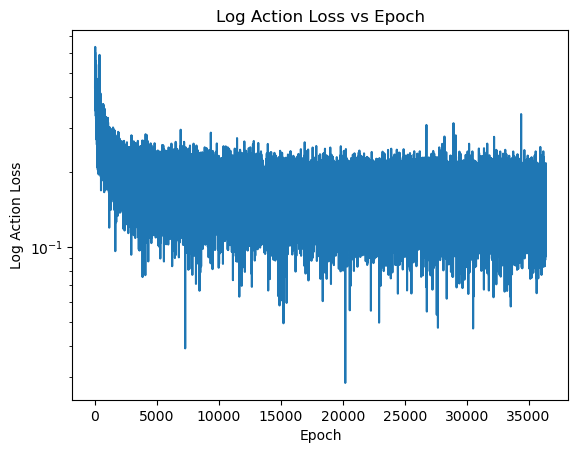

In [25]:
import matplotlib.pyplot as plt
# TODO test the plot
plt.plot(log_action_losses)
plt.xlabel('Epoch')
plt.ylabel('Log Action Loss')
plt.yscale('log')
plt.title('Log Action Loss vs Epoch')
plt.show()

In [26]:
import json

# save model using torch.save() and save it to a directory
directory = 'model'
model_name = 'AAPL_model.pt'
if not os.path.exists(directory):
     os.makedirs(directory)
torch.save(model.state_dict(), os.path.join(directory, model_name))

# write model parameters to a json file

model_params = {
     'state_dim': state_dim,
     'act_dim': act_dim,
     'n_blocks': n_blocks,
     'h_dim': h_dim,
     'context_len': context_len,
     'n_heads': n_heads,
     'drop_p': drop_p,
}
with open(os.path.join(directory, 'AAPL_model_params.json'), 'w') as f:
     json.dump(model_params, f)